# Discrimination between $t\bar{t}$ in the all-jet final state and QCD

In [83]:
%matplotlib inline
import sys
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from uncertainty import compute_variation_ratio
from uncertainty import compute_predictive_entropy
from uncertainty import compute_mutual_information

In [3]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [4]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Loading and Preprocessing

In [5]:
npz_file = np.load('../data/ttbar-all-jets_vs_QCD.npz')
for each in npz_file.keys():
    print(each)

tt
feature_name
qcd


In [6]:
x_tt = npz_file['tt']
x_qcd = npz_file['qcd']
feature_name = npz_file['feature_name']

In [7]:
print(x_tt.shape)
print(x_qcd.shape)

(35000, 6, 9)
(35000, 6, 9)


In [8]:
print(feature_name)
print()
print(feature_name[0])

[[b'jet_1_pt' b'jet_1_eta' b'jet_1_phi' b'jet_1_num_charged'
  b'jet_1_num_neutral' b'jet_1_major_axis' b'jet_1_minor_axis'
  b'jet_1_ptd' b'jet_1_b_tag']
 [b'jet_2_pt' b'jet_2_eta' b'jet_2_phi' b'jet_2_num_charged'
  b'jet_2_num_neutral' b'jet_2_major_axis' b'jet_2_minor_axis'
  b'jet_2_ptd' b'jet_2_b_tag']
 [b'jet_3_pt' b'jet_3_eta' b'jet_3_phi' b'jet_3_num_charged'
  b'jet_3_num_neutral' b'jet_3_major_axis' b'jet_3_minor_axis'
  b'jet_3_ptd' b'jet_3_b_tag']
 [b'jet_4_pt' b'jet_4_eta' b'jet_4_phi' b'jet_4_num_charged'
  b'jet_4_num_neutral' b'jet_4_major_axis' b'jet_4_minor_axis'
  b'jet_4_ptd' b'jet_4_b_tag']
 [b'jet_5_pt' b'jet_5_eta' b'jet_5_phi' b'jet_5_num_charged'
  b'jet_5_num_neutral' b'jet_5_major_axis' b'jet_5_minor_axis'
  b'jet_5_ptd' b'jet_5_b_tag']
 [b'jet_6_pt' b'jet_6_eta' b'jet_6_phi' b'jet_6_num_charged'
  b'jet_6_num_neutral' b'jet_6_major_axis' b'jet_6_minor_axis'
  b'jet_6_ptd' b'jet_6_b_tag']]

[b'jet_1_pt' b'jet_1_eta' b'jet_1_phi' b'jet_1_num_charged'
 b'jet_1

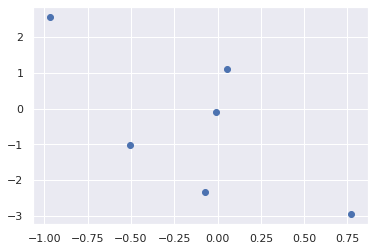

In [9]:
eta = x_tt[0, :, 1]
phi = x_tt[0, :, 2]

plt.scatter(eta, phi)

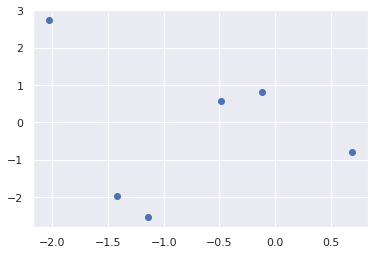

In [10]:
eta = x_qcd[3, :, 1]
phi = x_qcd[3, :, 2]

plt.scatter(eta, phi)

In [11]:
y_qcd = np.zeros(len(x_qcd), dtype=np.int64)
y_tt = np.ones(len(x_tt), dtype=np.int64)

x = np.concatenate([x_qcd, x_tt])
y = np.concatenate([y_qcd, y_tt])

num_examples = len(x)

x = x.reshape(num_examples, -1)

x, y = shuffle(x, y)
y = tfk.utils.to_categorical(y).astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [12]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

Datasets = namedtuple('Datasets', ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test'])
datasets = Datasets(x_train, y_train, x_valid, y_valid, x_test, y_test)

# Data Visualization

In [13]:
num_vis = min(len(x_test), 2000)
vis_indices = np.random.choice(np.arange(len(x_test)), num_vis)
x_vis = x_test[vis_indices]
y_vis = y_test[vis_indices]

In [14]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_vis)

In [15]:
df = {'x_embed{}'.format(i): x_embed[:, i] for i in range(2)}
df['y'] = y_vis[:, 1]
df = pd.DataFrame(df)

Text(0.5, 1.0, 't-SNE')

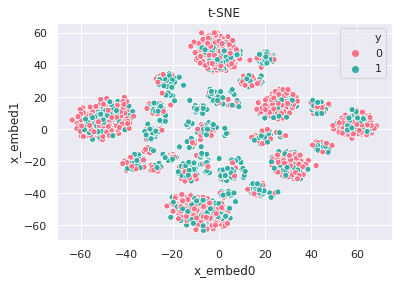

In [16]:
ax = sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")
ax.set_title("t-SNE")

In [17]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

def run_experiment(model,
                   loss,
                   datasets,
                   log_name,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy'])

    history = model.fit(
        datasets.x_train,
        datasets.y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(datasets.x_valid, datasets.y_valid),
        verbose=0,
        callbacks=[tf.keras.callbacks.TensorBoard(log_name)])


    loss, acc = model.evaluate(datasets.x_test, datasets.y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")

    plot_learning_curve(history, title)
    return acc

# Deterministic Deep Model

In [18]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfkl.Dense(128),
    tfkl.ReLU(),
    tfkl.Dense(y_train.shape[-1]),
    tfkl.Softmax(),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 7,298
Trainable params: 7,298
Non-trainable params: 0
_________________________________________________________________


W0730 22:15:00.041457 140021266048832 deprecation.py:323] From /home/slowmoyang/Installations/anaconda3/envs/py36-tf114/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loss: 0.4483
Accuracy: 0.7973


0.79728574

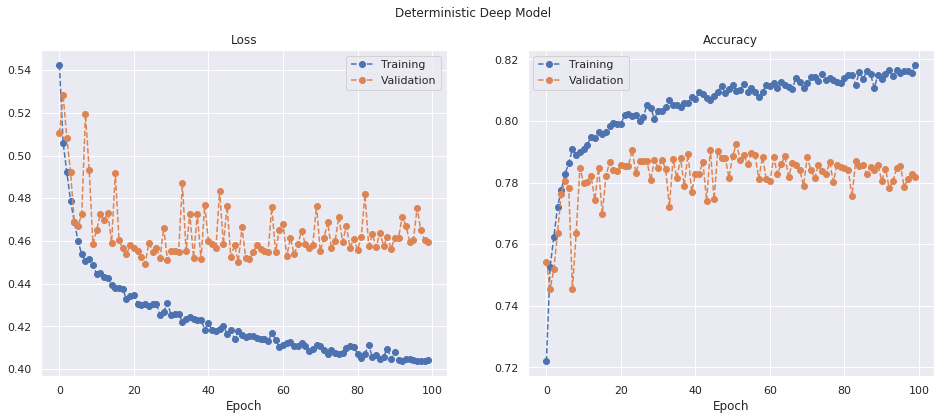

In [19]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    datasets=datasets,
    log_name='logs-deterministic',
    title='Deterministic Deep Model',
    learning_rate=0.01,
    epochs=100)

In [20]:
%load_ext tensorboard
# Start TENSORBOARD
%tensorboard --logdir logs-deterministic

Reusing TensorBoard on port 6007 (pid 32049), started 0:22:18 ago. (Use '!kill 32049' to kill it.)

# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [21]:
kl_weight = 1 / len(x_train)
print(kl_weight)

2.380952380952381e-05


In [22]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [23]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    # NOTE When c = np.log(np.expm1(1.)), training is very unstable
    c = np.log(np.expm1(1.))
    # c = 0
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [24]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [25]:
def evaluate(model, x, y, num_monte_carlo=100):
    samples = tf.stack([model(x).probs for _ in range(num_monte_carlo)]).numpy()[:, :, 1]
    y_hat = samples.mean(axis=0)
    y = y[:, 1]
    accuracy = ((y_hat > 0.5).astype(int) == y).mean()
    print(f"Accuracy: {accuracy}")
    return accuracy

# Deep Bayesian Model

In [26]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(y_train.shape[-1]),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 128)               21120     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 2), (None, 2))    0         
Total params: 21,507
Trainable params: 21,507
Non-trainable params: 0
_________________________________________________________________


Loss: 0.5046
Accuracy: 0.6714
Accuracy: 0.7607857142857143


0.7607857142857143

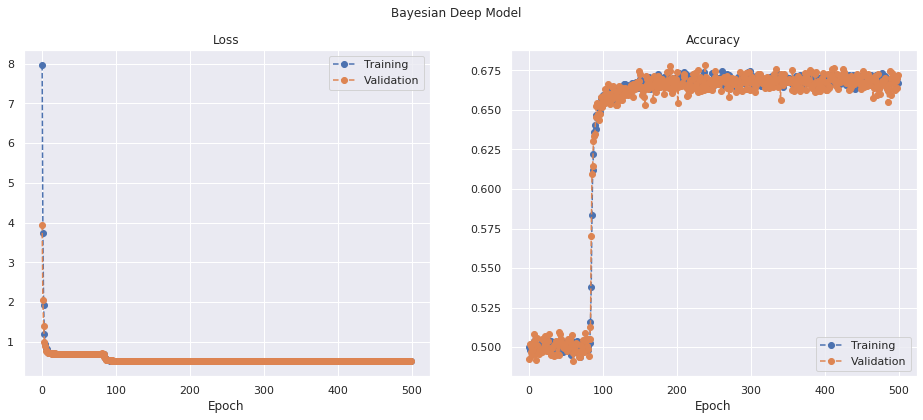

In [27]:


model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               log_name='logs-bayesian',
               title='Bayesian Deep Model',
               learning_rate=0.01,
               epochs=500)


evaluate(model, datasets.x_test, datasets.y_test)

# %load_ext tensorboard
# Start TENSORBOARD
# %tensorboard --logdir logs-bayesian

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 26849), started 4:46:14 ago. (Use '!kill 26849' to kill it.)

# Performance metrics

In [29]:
num_monte_carlo = 100
prediction_samples = tf.stack([model(x_test).probs for _ in range(num_monte_carlo)]).numpy()

In [30]:
predictive_mean = prediction_samples[:, :, 1].mean(axis=0)
predictive_variance = prediction_samples[:, :, 1].var(axis=0)

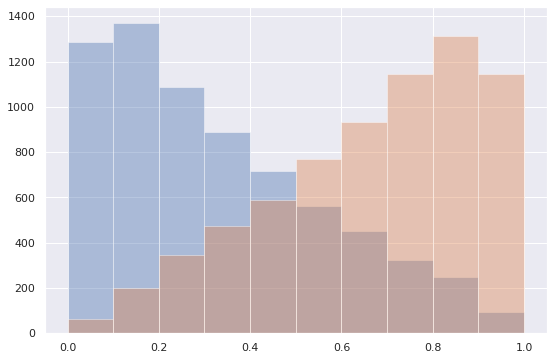

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))

hist_kwargs = {
    'range': (0, 1),
    'bins': 10,
    #'density': True,
    'alpha': 0.4,
}

_ = ax.hist(predictive_mean[y_test[:, 1] == 0], **hist_kwargs)
_ = ax.hist(predictive_mean[y_test[:, 1] == 1], **hist_kwargs)

In [32]:
fpr, tpr, _ = metrics.roc_curve(y_true=y_test[:, 1], y_score=predictive_mean)
tnr = 1 - fpr
auc = metrics.auc(tpr, tnr)

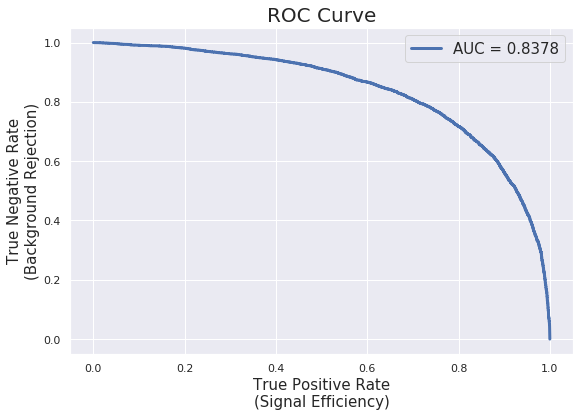

In [33]:
fig, ax = plt.subplots(figsize=(9, 6))

label = 'AUC = {:.4f}'.format(auc)

_ = ax.plot(tpr, tnr, label=label, lw=3)

ax.legend(fontsize=15, loc='best')

_ = ax.set_title("ROC Curve", fontsize=20)

_ = ax.set_xlabel('True Positive Rate\n(Signal Efficiency)', fontdict={'size': 15})
_ = ax.set_ylabel('True Negative Rate\n(Background Rejection)', fontdict={'size': 15})

# Uncertainty

In [34]:
variation_ratio = compute_variation_ratio(prediction_samples)
predictive_entropy = compute_predictive_entropy(prediction_samples)
mutual_information = compute_mutual_information(prediction_samples)

In [114]:
def plot_uncertainty(mu, uncertainty, title=None, color='inferno'):
    if isinstance(color, str):
        color = sns.color_palette(color)
    
    
    is_zero = y_test[:, 1] == 0
    is_one = y_test[:, 1] == 1
    
    # fig, axarr = plt.subplots(ncols=2, figsize=(12, 6))
    
    # axarr[0].scatter(mu[is_zero], uncertainty[is_zero], s=5, alpha=0.1)
    # axarr[1].scatter(mu[is_one], uncertainty[is_one], s=5, alpha=0.1)
    
    # sns.kdeplot(mu[is_zero], uncertainty[is_zero], ax=axarr[0], cmap='Reds', cbar=True, shade=True, shade_lowest=False)
    # sns.kdeplot(mu[is_one], uncertainty[is_one], ax=axarr[1], cmap='Blues', cbar=True, shade=True, shade_lowest=False)
    sns.set_style('white')
    
    ax0 = sns.jointplot(x=mu[is_zero], y=uncertainty[is_zero],  kind="hex", color='lightcoral')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
    cbar_ax = ax0.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
    plt.colorbar(cax=cbar_ax)
    
    
    ax1 = sns.jointplot(x=mu[is_one], y=uncertainty[is_one], kind="hex", color='cornflowerblue')
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
    cbar_ax = ax1.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
    plt.colorbar(cax=cbar_ax)


    if title is not None:
        fig.suptitle(title)

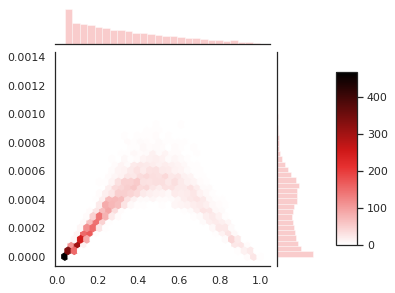

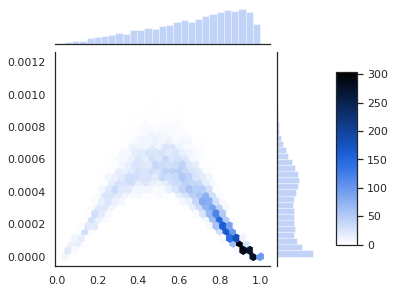

In [115]:
plot_uncertainty(predictive_mean, predictive_variance, title='Predictive Variance')

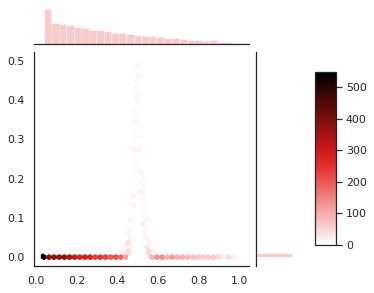

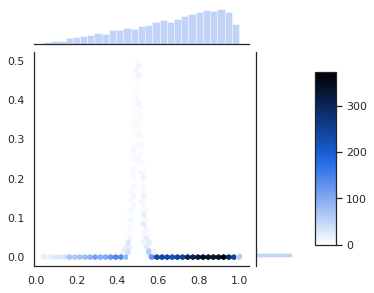

In [117]:
plot_uncertainty(predictive_mean, variation_ratio, title='Variation Ratio')

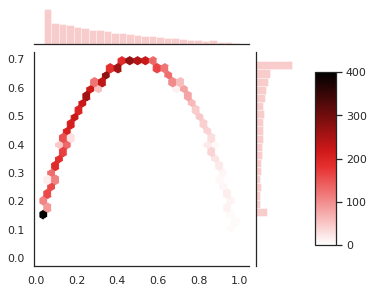

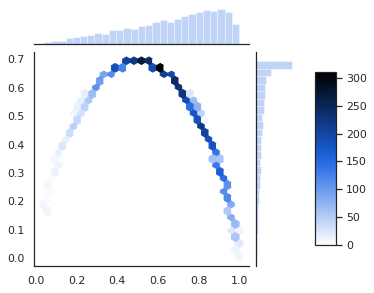

In [119]:
plot_uncertainty(predictive_mean, predictive_entropy, title="Predictive Entropy")

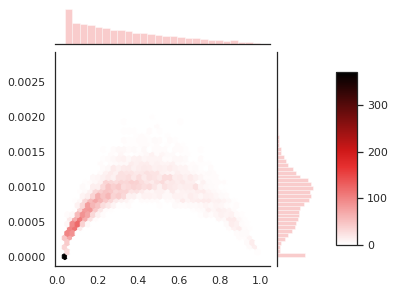

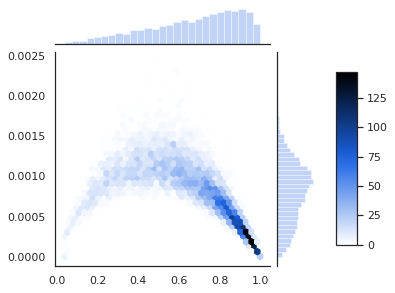

In [121]:
plot_uncertainty(predictive_mean, mutual_information, title="Mutual Information")

In [122]:
y_pred = predictive_mean > 0.5
y_true = y_test[..., 1]

In [123]:
def draw_uncertainty(y_true, y_pred,
                     uncertainty,
                     uncertainty_name,
                     title, log=False):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal = [
        uncertainty[is_true_pos],
        uncertainty[is_false_neg]
    ]

    background = [
        uncertainty[is_true_neg],
        uncertainty[is_false_pos]
    ]

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    suptitle = fig.suptitle(title, fontsize="x-large")

    signal_hists, _, _ = axarr[0].hist(
        signal,
        label=["signal (Correct)", "signal (Incorrect)"],
        color=['skyblue', 'b'],
        stacked=True, bins=50, alpha=0.3)

    background_hists, _, _ = axarr[1].hist(
        background,
        label=["background (Correct)", "background (Incorrect)"],
        color=['lightcoral', 'r'],
        stacked=True, bins=50, alpha=0.5)

    max_value = max(each.max() for each in signal_hists + background_hists)
    y_max = 1.05 * max_value

    for ax in axarr:
        ax.grid()
        ax.legend(fontsize=15)
        ax.set_xlabel(uncertainty_name)
        if log:
            ax.set_yscale('log')

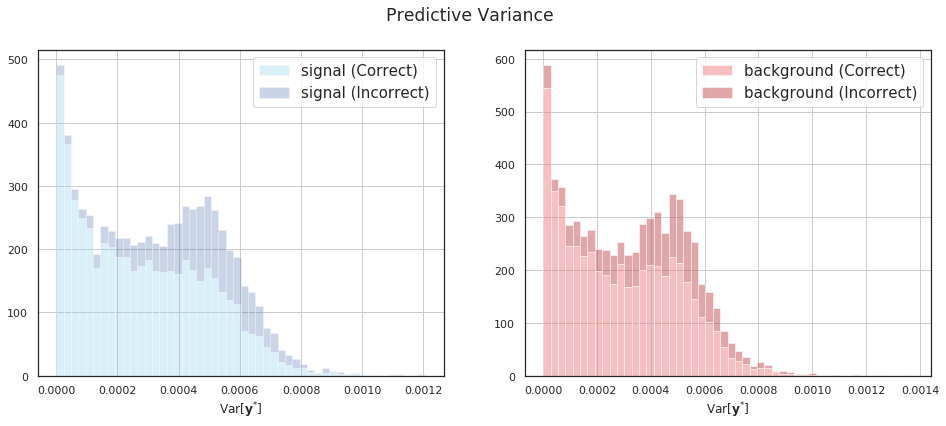

In [124]:
draw_uncertainty(y_true, y_pred, predictive_variance, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Variance')

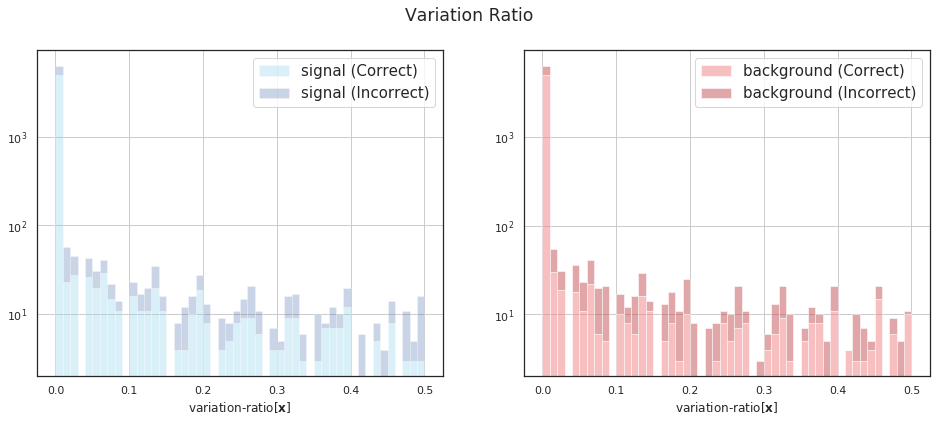

In [125]:
draw_uncertainty(y_true, y_pred, variation_ratio, r'variation-ratio[$\mathbf{x}$]', 'Variation Ratio', True)

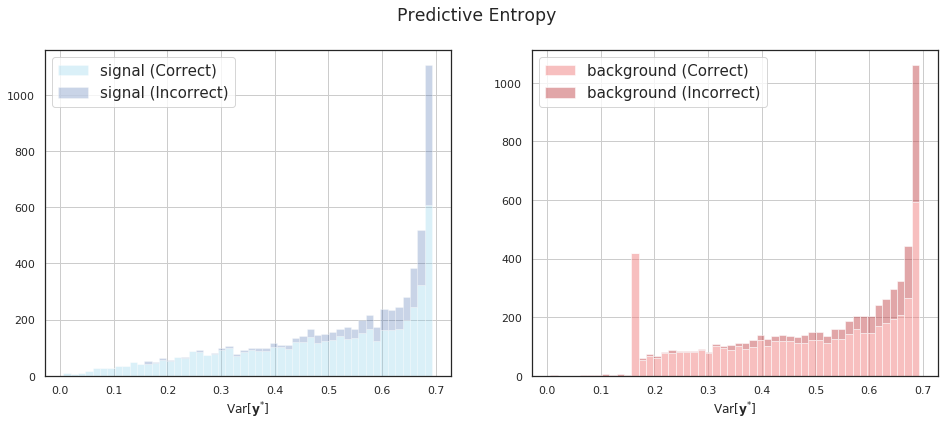

In [126]:
draw_uncertainty(y_true, y_pred, predictive_entropy, r'Var$[ \mathbf{y}^{*}]$', 'Predictive Entropy')

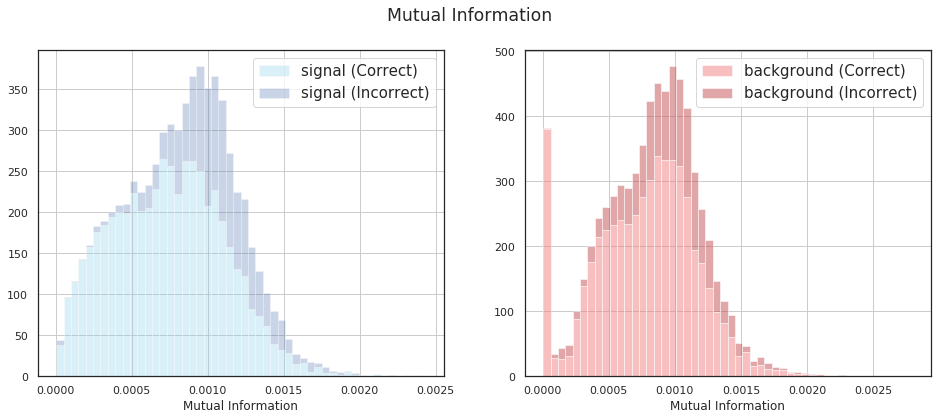

In [127]:
draw_uncertainty(y_true, y_pred, mutual_information, 'Mutual Information', 'Mutual Information')

# Signal Efficiency vs Significance

In [133]:
def draw_curve(y_true, y_pred,
               uncertainty,
               title):
    
    is_sig = y_true == 1
    is_bkg = y_true == 0

    is_true_pos = np.logical_and(is_sig, y_pred == 1)
    is_false_neg = np.logical_and(is_sig, y_pred == 0)

    is_true_neg = np.logical_and(is_bkg, y_pred == 0)
    is_false_pos = np.logical_and(is_bkg, y_pred == 1)
    
    
    signal_efficiency = []
    background_efficiency = []
    for cut in np.linspace(uncertainty.min(), uncertainty.max()):
        good = uncertainty < cut
        
        if sum(good) == 0:
            continue
        
        sig_eff = sum(is_true_pos[good]) / sum(is_sig)
        bkg_eff = sum(is_false_pos[good]) / sum(is_bkg)
        
        signal_efficiency.append(sig_eff)
        background_efficiency.append(bkg_eff)

    sig_eff = np.array(signal_efficiency)
    bkg_eff = np.array(background_efficiency)

    fig, ax = plt.subplots(figsize=(6, 4))
    suptitle = fig.suptitle(title, fontsize="x-large")

    # NOTE
    safe_idx = bkg_eff.nonzero()
    bkg_eff = bkg_eff[safe_idx]
    sig_eff = sig_eff[safe_idx]

    inv_sqrt_bkg_eff = 1 / np.sqrt(bkg_eff)
    line1 = ax.plot(sig_eff, inv_sqrt_bkg_eff,
                    marker="o", ls="--", color="mediumorchid",
                    label=r"$1 / \sqrt{\epsilon_{B}}$")
    ax.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    ax.set_ylabel(r"$1 / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # ax.grid()

    # NOTE
    twinx = ax.twinx()

    significance = sig_eff / np.sqrt(bkg_eff)
    line2 = twinx.plot(sig_eff, significance,
                       marker="^", ls="--", color="darkgreen",
                       label=r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$")
    twinx.set_xlabel(r"$\epsilon_{S}$", fontdict={'size': 20})
    twinx.set_ylabel(r"$\epsilon_{S} / \sqrt{\epsilon_{B}}$", fontdict={'size': 20})
    # twinx.grid()

    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, fontsize=20, loc='center right')
    
    return significance.max()

1.6931396694895249

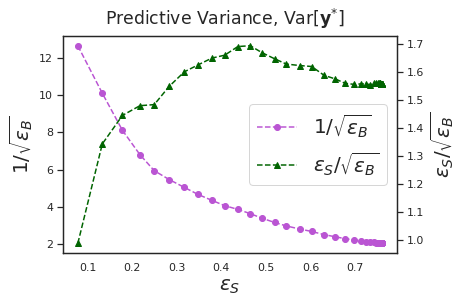

In [134]:
draw_curve(y_true, y_pred, predictive_variance, r'Predictive Variance, Var$[\mathbf{y}^{*}]$')

1.6374132420752978

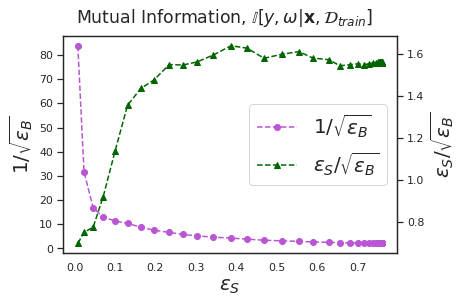

In [135]:
draw_curve(y_true, y_pred, mutual_information,
           r'Mutual Information, $ \mathbb{I}[y,\omega|\mathbf{x},\mathcal{D}_{train}]$')

1.594694545344317

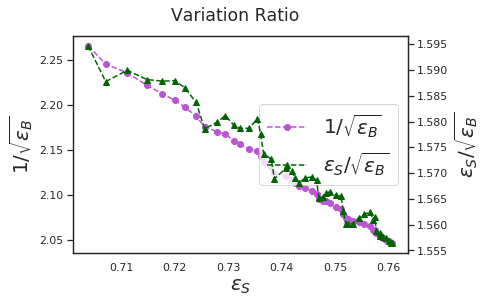

In [136]:
draw_curve(y_true, y_pred, variation_ratio, 'Variation Ratio')

1.6940637903584437

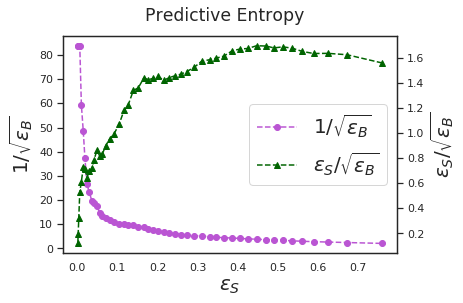

In [137]:
draw_curve(y_true, y_pred, predictive_entropy, 'Predictive Entropy')